In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##import dependencies

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import math
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.metrics import categorical_accuracy

#from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger

In [ ]:
# get all the directories of the data
train= '/content/drive/MyDrive/Colab Notebooks/primary_small/train'
valid= '/content/drive/MyDrive/Colab Notebooks/primary_small/valid'
test= '/content/drive/MyDrive/Colab Notebooks/primary_small/test'
classes = ["brightpixel", "narrowband","narrowbanddrd","noise","squarepulsednarrowband","squiggle","squigglesquarepulsednarrowband"]

## resnet model

In [ ]:
train_batch_size = 32
img_dim = (192, 192)
classes = ['brightpixel', 'narrowband','narrowbanddrd', 'noise',  'squarepulsednarrowband', 'squiggle','squigglesquarepulsednarrowband']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15,
                                     zoom_range=0.2,
                                     fill_mode = 'nearest') 
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train, classes=classes, target_size=img_dim, 
                                                    batch_size=train_batch_size, class_mode='categorical', interpolation='bicubic',
                                                   shuffle=True, seed=42)

val_generator = valid_datagen.flow_from_directory(directory=valid, classes = classes, target_size=img_dim, batch_size=64,
                                                 class_mode='categorical', shuffle=False, seed=42, interpolation='bicubic')

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


##imagenet base of resnet

In [ ]:
input_shape = (192, 192, 3)
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
resnet.trainable = True
for layer in resnet.layers:
    resnet.trainable = True

94765736/94765736 [==============================] - 3s 0us/step


##added latent layer

In [ ]:
base_resnet = resnet
base_out = base_resnet.output
pool_out = Flatten()(base_out)
hidden1 = Dense(1024, activation='relu')(pool_out)
drop1 = Dropout(rate=0.2)(hidden1)
hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.2)(hidden2)
srilayer = Dense(64, activation='relu', name ="sri")(drop2)
drop3 = Dropout(rate=0.2)(srilayer)

out = Dense(7, activation='softmax')(drop3)

model = Model(inputs = base_resnet.input, outputs=out)
model.compile(optimizer=RMSprop(lr=1e-5), loss='categorical_crossentropy', metrics=[categorical_accuracy])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#model.summary()

In [ ]:
csv_logger = CSVLogger('resent50_finetune_full_seti_log.csv', append=True)

history = model.fit_generator(train_generator, epochs = 40, 
                              validation_data=val_generator, callbacks=[csv_logger], verbose=1)

<ipython-input-10-3ae68cbe3cf9>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 40,


Epoch 1/40
175/175 [==============================] - 2713s 15s/step - loss: 1.7873 - categorical_accuracy: 0.3496 - val_loss: 5.4903 - val_categorical_accuracy: 0.1429
Epoch 2/40
175/175 [==============================] - 148s 845ms/step - loss: 1.2539 - categorical_accuracy: 0.5521 - val_loss: 23.6825 - val_categorical_accuracy: 0.1429
Epoch 3/40
175/175 [==============================] - 142s 813ms/step - loss: 1.0686 - categorical_accuracy: 0.6327 - val_loss: 24.7096 - val_categorical_accuracy: 0.1429
Epoch 4/40
175/175 [==============================] - 145s 827ms/step - loss: 0.9345 - categorical_accuracy: 0.6823 - val_loss: 21.5110 - val_categorical_accuracy: 0.1429
Epoch 5/40
175/175 [==============================] - 143s 816ms/step - loss: 0.8752 - categorical_accuracy: 0.7016 - val_loss: 12.2441 - val_categorical_accuracy: 0.1529
Epoch 6/40
175/175 [==============================] - 142s 808ms/step - loss: 0.8242 - categorical_accuracy: 0.7359 - val_loss: 1.6097 - val_catego

##load xtrain from drive 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
LatentPart = Model(inputs=model.input,outputs=model.get_layer('sri').output)


In [11]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)


In [ ]:
#https://drive.google.com/file/d/1-2rXoqYiY0MV_kyQZ3mvgp6QXgSJpiws/view?usp=share_link
fileDownloaded = drive.CreateFile({'id':'1-2rXoqYiY0MV_kyQZ3mvgp6QXgSJpiws'})
fileDownloaded.GetContentFile('xtrain.npy')

In [12]:
#https://drive.google.com/file/d/1-2rXoqYiY0MV_kyQZ3mvgp6QXgSJpiws/view?usp=share_link
#https://drive.google.com/file/d/1-2Tl26RzFojKt7qNjdd3pOQ48O2NKwrj/view
fileDownloaded = drive.CreateFile({'id':'1-2Tl26RzFojKt7qNjdd3pOQ48O2NKwrj'})
fileDownloaded.GetContentFile('ytrain.npy')

In [13]:
ytrain = np.load('ytrain.npy')
print(ytrain.shape)

(3360, 7)


In [ ]:
xtrain = np.load('xtrain.npy')
#ytrain = np.load('ytrain.npy')
print(xtrain.shape)
#print(ytrain.shape)

(3360, 192, 192, 3)


##train on resnet model and reshape for svm

In [ ]:
X_train_encoded = LatentPart.predict(xtrain)

105/105 [==============================] - 8s 68ms/step


In [ ]:
X_train_encoded.shape

(3360, 64)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks
from numpy import save
save('x_encoded.npy', X_train_encoded)

/content/drive/MyDrive/Colab Notebooks


In [ ]:
########### CHECK POINT

In [ ]:
3360*64

215040

In [ ]:
#X_train_encoded = np.reshape(X_train_encoded, (3360,392))

In [ ]:
#X_train_encoded.shape

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [14]:
a = np.argmax(ytrain, axis=1)

In [16]:
%cd /content/drive/MyDrive/Colab Notebooks
from numpy import save
save('y_encoded.npy', a)

/content/drive/MyDrive/Colab Notebooks


In [17]:
%cd /content/drive/MyDrive/Colab Notebooks
# load numpy array from npy file
from numpy import load
# load array
X_train_encoded = load('x_encoded.npy')
# print the array
a = load('y_encoded.npy')

/content/drive/MyDrive/Colab Notebooks


In [8]:
X_train_encoded.shape

(3360, 64)

In [18]:
print(a.shape)
r = a.flatten()
print(r.shape)

(3360,)
(3360,)


Populating the interactive namespace from numpy and matplotlib
(3360, 64)
(3360, 2)


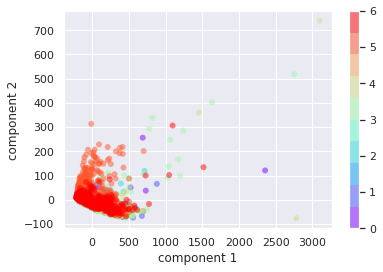

In [22]:
%pylab inline 
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X_train_encoded)
print(X_train_encoded.shape)
print(projected.shape)

plt.scatter(projected[:, 0], projected[:, 1],
            c=a, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.savefig('TSEjN.png', dpi =500)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded,a, test_size=.3)

##train SVM model

In [ ]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
#svm.fit(feat_train,train_labels)
svm.fit(X_train, y_train)

SVC(gamma='auto')

In [ ]:
from sklearn.svm import SVC
svm = SVC(gamma='auto')
svm.fit(X_train, y_train)
predtrain = svm.predict(X_train)
predtest = svm.predict(X_test)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtrain,y_train))
print("Training Sensitivity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training Specificity:",metrics.recall_score(predtrain,y_train, average='macro'))
print("Training precision:",metrics.precision_score(predtrain,y_train, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtrain,y_train, average='macro' ))
print("Training F1 Score:",f1_score(predtrain,y_train, average='macro'))

Training Accuracy: 0.9931972789115646
Training Sensitivity: 0.9934168586522848
Training Specificity: 0.9934168586522848
Training precision: 0.993193483660818
Training Recall: 0.9934168586522848
Training F1 Score: 0.9932593753566117


In [ ]:
predtrain = svm.predict(X_train)
predtest = svm.predict(X_test)
svm.score(X_test,y_test)
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

print("Training Accuracy:",metrics.accuracy_score(predtest,y_test))
print("Training Sensitivity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Training Specificity:",metrics.recall_score(predtest,y_test, average='macro'))
print("Training precision:",metrics.precision_score(predtest,y_test, average='macro', zero_division=1))
print("Training Recall:",metrics.recall_score(predtest,y_test, average='macro' ))
print("Training F1 Score:",f1_score(predtest,y_test, average='macro'))

Training Accuracy: 0.18253968253968253
Training Sensitivity: 0.30615393886003445
Training Specificity: 0.30615393886003445
Training precision: 0.19953996480023586
Training Recall: 0.30615393886003445
Training F1 Score: 0.15337784758564302
